In [1]:
# Imports
import glob
import numpy as np
from nilearn import image, plotting
from nilearn.image import new_img_like
import os
import scipy.io

C:\Users\davide\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
C:\Users\davide\anaconda3\lib\site-packages\nilearn\datasets\__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
main_folder = 'C:\\Users\\davide\\Documents\\GitHub\\wp1_2_roast' #main folder with data
bck_img_map = image.load_img(os.path.join(main_folder, 'MNI152_T1_1mm_Brain.nii')) #Background for plotting purposes
#List of subjects
#subjects = ['01','02','03','04','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','22','23','24']
subjects = ['01','02','03','04','07','08','09','10','11','12','13','14','15','16','17','18','19','20','22','23','24']

subjects = ['01','02']

dcm_data_day1_path = os.path.join(main_folder,'Day1_all_EPvalues.mat') #mat file with DCM results of day 1
dcm_data_day1 = scipy.io.loadmat(dcm_data_day1_path)
#NB this file contains results for all 22 subjects for all 3 polarities (anodal, cathodal and sham)
#And the order is anodal, cathodal and sham for each subject (so I'm only interested in matrices 0, 3, 6 ... etc)

In [3]:
#Loading ROIs
m1_path = os.path.join(main_folder,'rois','m1.nii')
th_path = os.path.join(main_folder,'rois','th.nii')
m1 = image.load_img(m1_path)
th = image.load_img(th_path)

Analysing subject: 01
Path: D:\roast-chapter3\wp2a_copy\sub-01
M1<->M1 connectivity: 0.05520965013149901
Th<->M1 connectivity: -0.07975793559423307
Mean Electric field value in M1: 0.38159543083071673
Mean Electric field value in Th: 0.07944123027842594
Median Electric field value in M1: 0.15022442015164472
Median Electric field value in Th: 0.07836062443852149
Max Electric field value in M1: 3.751352817391213
Max Electric field value in Th: 0.12244959906183672


Analysing subject: 02
Path: D:\roast-chapter3\wp2a_copy\sub-02
M1<->M1 connectivity: -0.3622170140993727
Th<->M1 connectivity: 0.009976267482675176
Mean Electric field value in M1: 0.34374994727384833
Mean Electric field value in Th: 0.07756179443678486
Median Electric field value in M1: 0.13189526353335201
Median Electric field value in Th: 0.07735369867961703
Max Electric field value in M1: 3.4642983397160565
Max Electric field value in Th: 0.12048958593597558




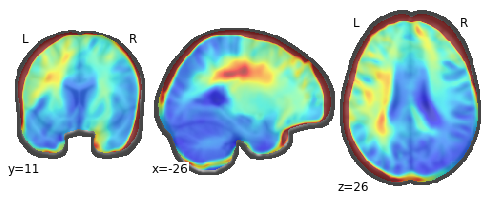

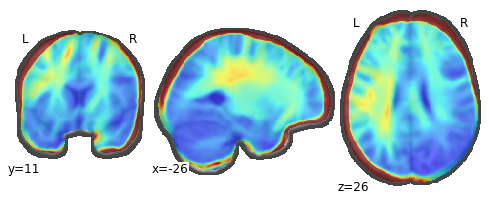

In [5]:
pos_dcm_res = 0 #Position of the DCM results for subject 1, day 1 (anodal)

# Where I'll save m1 self connections and all th->m1
all_m1selfcon = []
all_thm1 = []

# Where I'll save emag values for m1 and th for each subject (means, medians, max values)
all_m1_emag_means = []
all_th_emag_means = []
all_m1_emag_medians = []
all_th_emag_medians = []
all_m1_emag_max = []
all_th_emag_max = []

for sbj in subjects:
    print('Analysing subject: ' + sbj)
    path = 'D:\\roast-chapter3\wp2a_copy\sub-' + sbj
    print('Path: ' + path)
    
    #Loading ROAST Electric field magnitude simulation (V/m)
    emag_map = image.load_img(glob.glob(path+ '/wsub-*_T1_*_emag.nii'))    
    emag_data = emag_map.get_fdata().reshape([157,189,156]) # needed to drop 4th dimention in the array (that shouldn't be there)
    emag_map = new_img_like(emag_map,emag_data) 
    
    # Applying fwhm smoothing to the electric field magnitude map. Kernel 4x4x4
    emag_map_smoothed = image.smooth_img(emag_map, fwhm=4) # Emag map

    # Loading masks containing grey matter, white matter and csf
    grey_matter = image.load_img(glob.glob(path+ '/wc1sub*.nii')).get_fdata().reshape([157,189,156]) 
    white_matter = image.load_img(glob.glob(path+ '/wc2sub*.nii')).get_fdata().reshape([157,189,156])
    csf = image.load_img(glob.glob(path+ '/wc3sub*.nii')).get_fdata().reshape([157,189,156])
    
    # Resampling MNI anatomical file to emag map (so that they have the same shape)
    mni_resampled = image.resample_to_img(bck_img_map, emag_map, interpolation = 'nearest')    
    
    #Emag map masked (to exclude the skull, and keep only values of voxels in the brain)
    emag_map_masked = image.math_img("np.where(img2 != 0, img, 0)", img=emag_map_smoothed, img2 = mni_resampled)
    
    # Resampling ROIs to the dimention of the emag map
    m1_resampled = image.resample_to_img(m1, emag_map_masked, interpolation = 'nearest')
    th_resampled = image.resample_to_img(th, emag_map_masked, interpolation = 'nearest')
    
    #Loading DCM results for the subject
    this_dcm = np.array(dcm_data_day1['ALLEP'][0][pos_dcm_res].todense().reshape((4,4)))   
    #print(this_dcm) # If you want to see the whole connectivity matrix for each subject
    
    # I am only interested in m1 self connectivity and th->m1
    m1m1 = this_dcm[0][0]
    thm1 = this_dcm[0][1]
    
    # Saving the values
    all_m1selfcon.append(m1m1)
    all_thm1.append(thm1)
    
    print('M1<->M1 connectivity: ' + str(m1m1))
    print('Th<->M1 connectivity: ' + str(thm1))

    # Calculating the mean of the electric field intensity for M1 and TH
    # For this I first need to mask the emag map
    emag_masked_m1 = image.math_img("img * img2", img=emag_map_masked, img2 = m1_resampled) #Applying m1 mask
    emag_masked_th = image.math_img("img * img2", img=emag_map_masked, img2 = th_resampled) #Applying th mask
    
    # Assigning nans to zeroes to exclude non M1 voxels from the calculation of the mean
    emag_masked_m1_nans = np.where(m1_resampled.get_fdata() == 0, np.nan, emag_masked_m1.get_fdata())
    emag_masked_th_nans = np.where(th_resampled.get_fdata() == 0, np.nan, emag_masked_th.get_fdata())

    # Calculating means
    m1_emag_mean = np.nanmean(emag_masked_m1_nans)
    th_emag_mean = np.nanmean(emag_masked_th_nans)
    m1_emag_median = np.nanmedian(emag_masked_m1_nans)
    th_emag_median = np.nanmedian(emag_masked_th_nans)
    m1_emag_max = np.nanmax(emag_masked_m1_nans)
    th_emag_max = np.nanmax(emag_masked_th_nans)
    
    
    # Saving the values
    all_m1_emag_means.append(m1_emag_mean)
    all_th_emag_means.append(th_emag_mean)   
    all_m1_emag_medians.append(m1_emag_median)
    all_th_emag_medians.append(th_emag_median)  
    all_m1_emag_max.append(m1_emag_max)
    all_th_emag_max.append(th_emag_max)   
    
    print('Mean Electric field value in M1: ' + str(m1_emag_mean))
    print('Mean Electric field value in Th: ' + str(th_emag_mean))
    print('Median Electric field value in M1: ' + str(m1_emag_median))
    print('Median Electric field value in Th: ' + str(th_emag_median))
    print('Max Electric field value in M1: ' + str(m1_emag_max))
    print('Max Electric field value in Th: ' + str(th_emag_max))
    print('\n')
    
    # For displaying purposes only I am smoothing the MNI template      
    if not 'bck_img_map_smoothed' in locals():
        bck_img_map_smoothed = image.smooth_img(bck_img_map, fwhm=2) # MNI template
        
    #Scroll down to see each individual EMAG map
    display = plotting.plot_roi(emag_map_masked,
                  bg_img = bck_img_map_smoothed,
                  dim = 0.5,
                  cmap = 'jet',
                  cut_coords = [-26,11,26],
                  threshold = 0.001,
                  vmin = 0,
                  vmax = 0.3,
                  alpha = 0.60,
                  draw_cross = False,
                  black_bg = False)
    
    
    pos_dcm_res += 3 #Moving to the next subject

In [ ]:
# Colorbar for the above brain plots
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=0.3)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='E-field magnitude (V/m)')

In [ ]:
# Descriptive statistics 
import seaborn as sns

all_m1_emag_means
all_th_emag_means
all_m1_emag_medians
all_th_emag_medians  
all_m1_emag_max
all_th_emag_max  
data = {'Means M1':all_m1_emag_means,'Means Th':all_th_emag_means, 
        'Medians M1':all_m1_emag_medians,'Medians Th':all_th_emag_medians,
        'Max values M1':all_m1_emag_max,'Max values Th':all_th_emag_max,}

sns.scatterplot(data=data, x ='Means M1')



In [ ]:
# Correlation m1 self connectivity and m1 electric field intensity
x = np.transpose(all_m1_emag_means)
y = np.transpose(all_m1selfcon)

r,p  = scipy.stats.pearsonr(x, y)    # Pearson's r
print('Correlation m1 self connectivity and m1 electric field intensity')
print('p value: ' + str(round(p,6)) + ', r=' + str(round(r,6)))

# Plot
from numpy.polynomial.polynomial import polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

In [ ]:
# Correlation th->m1 connectivity and m1 electric field intensity

x = np.transpose(all_m1_emag_means)
y = np.transpose(all_thm1)

r,p  = scipy.stats.pearsonr(x, y)    # Pearson's r
print('Correlation m1 self connectivity and m1 electric field intensity')
print('p value: ' + str(round(p,6)) + ', r=' + str(round(r,6)))

# Plot
from numpy.polynomial.polynomial import polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

In [ ]:
emag_map.get_fdata().shape